# Lab1 Feature extraction 2020.3.22

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from lab1_tools import *
from sklearn import mixture
from scipy.cluster.hierarchy import dendrogram, linkage

In [24]:
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()

In [25]:
example['samplingrate']  #means 1 digit equals 50μs

20000

In [26]:
example

{'samples': array([ 2,  2, -1, ..., -3, -7, -3], dtype=int16),
 'samplingrate': 20000,
 'frames': array([[  2.,   2.,  -1., ...,  -6.,  -6.,  -3.],
        [  3.,   4.,   5., ...,   0.,  -1.,   1.],
        [ -4.,   0.,  -1., ...,   0.,   0.,   1.],
        ...,
        [ 26.,  26.,  27., ...,  17.,  15.,  17.],
        [ -6.,  -7.,  -6., ...,   0.,   3.,   2.],
        [ 16.,  16.,  16., ...,  -9.,  -7., -10.]]),
 'preemph': array([[ 2.  ,  0.06, -2.94, ..., -0.18, -0.18,  2.82],
        [ 3.  ,  1.09,  1.12, ...,  0.  , -1.  ,  1.97],
        [-4.  ,  3.88, -1.  , ..., -0.97,  0.  ,  1.  ],
        ...,
        [26.  ,  0.78,  1.78, ...,  2.45, -1.49,  2.45],
        [-6.  , -1.18,  0.79, ..., -0.97,  3.  , -0.91],
        [16.  ,  0.48,  0.48, ..., -1.24,  1.73, -3.21]]),
 'windowed': array([[ 0.16      ,  0.0048034 , -0.23586733, ..., -0.01449192,
         -0.01444086,  0.22576003],
        [ 0.24      ,  0.08726186,  0.08985422, ...,  0.        ,
         -0.08022698,  0.1577118 ]

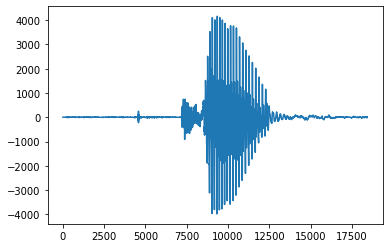

In [27]:
plt.plot(example['samples'])

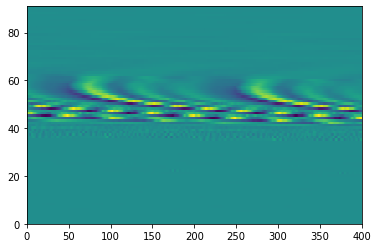

In [28]:
plt.pcolormesh(example['frames'])

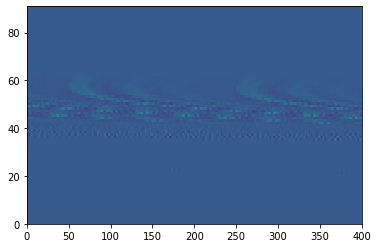

In [29]:
plt.pcolormesh(example['preemph'])

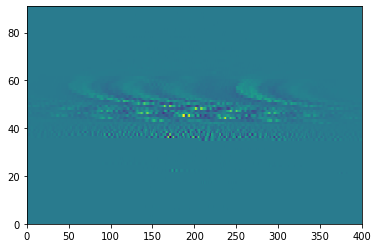

In [30]:
plt.pcolormesh(example['windowed'])

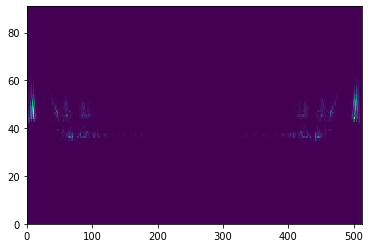

In [31]:
plt.pcolormesh(example['spec'])

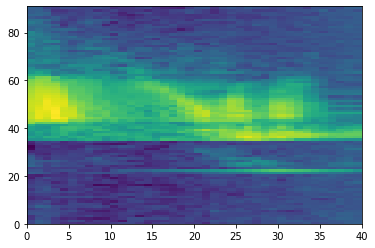

In [32]:
plt.pcolormesh(example['mspec'])

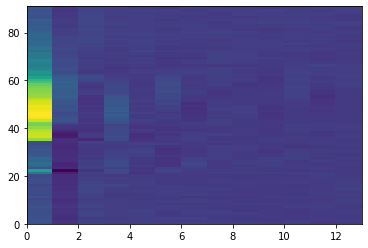

In [33]:
plt.pcolormesh(example['mfcc'])

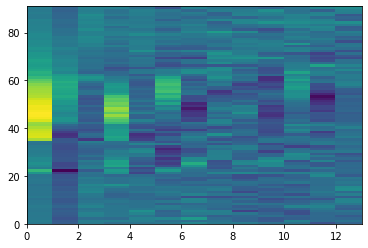

In [34]:
plt.pcolormesh(example['lmfcc'])

In [35]:
def enframe(samples, winlen, winshift):
    frame = np.array(samples[0:winlen].reshape((1, winlen)))
    for i in range(winlen - winshift, len(samples) - winlen, winlen - winshift):
        frame = np.vstack((frame,np.array(samples[i:i+winlen]).reshape((1,winlen))))
    return frame


In [36]:
frame = enframe(example['samples'], 400, 200)

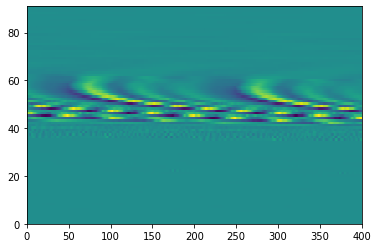

In [37]:
plt.pcolormesh(frame)

In [38]:
def preemp(input, p=0.97):
    a = [1]
    b = [1, -p]
    return signal.lfilter(b, a, input, zi=None)

In [39]:
preemp1 = preemp(frame)

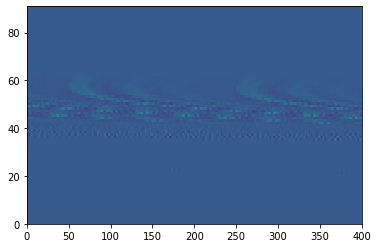

In [40]:
plt.pcolormesh(preemp1)

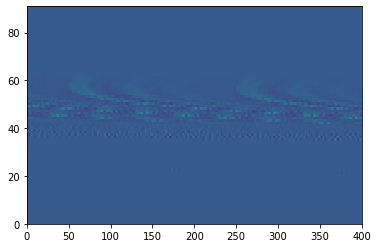

In [41]:
plt.pcolormesh(example['preemph'])

In [42]:
def windowing(input):
    window = signal.hamming(input.shape[1], sym=False)
    for idx, row in enumerate(input):
        input[idx] = window * input[idx]
    return input

In [43]:
window1 = windowing(preemp1)

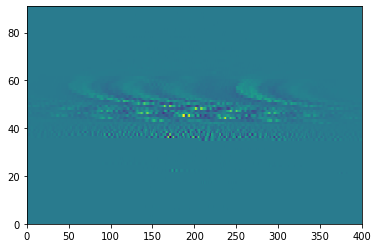

In [44]:
plt.pcolormesh(window1)

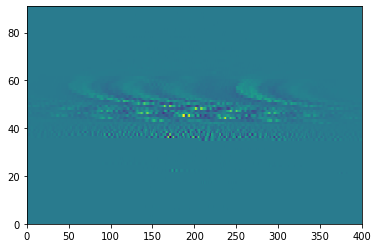

In [45]:
plt.pcolormesh(example['windowed'])

In [46]:
def powerSpectrum(input, nfft):
    return np.power(np.abs(fftpack.fft(input, nfft)), 2)
    #output = np.zeros((input.shape[0],512))
    #for idx, row in enumerate(input):
        #output[idx] = np.power(np.abs(fftpack.fft(input[idx], nfft)), 2)
    #return output

In [47]:
power1 = powerSpectrum(window1, 512)

In [48]:
power1.shape

(91, 512)

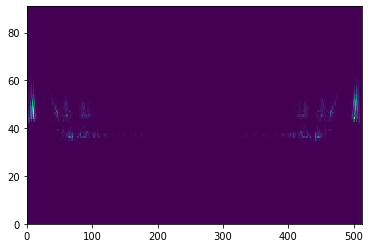

In [49]:
plt.pcolormesh(power1)

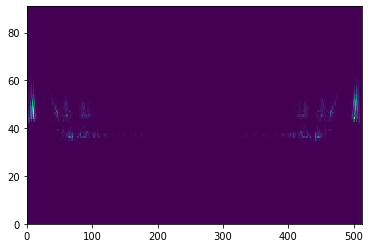

In [50]:
plt.pcolormesh(example['spec'])

In [51]:
def logMelSpectrum(input, samplingrate):
    T = trfbank(samplingrate, 512, lowfreq=133.33, linsc=200/3., logsc=1.0711703, nlinfilt=13, nlogfilt=27, equalareas=False)
    #Plot filter bank
    #for i in range(len(T)):
        #plt.plot(np.transpose(T[i]))
    #plt.show()
    Spec = np.dot(input, T.T)
    Spec = np.where(Spec == 0.0, np.finfo(float).eps, Spec)  # Numerical Stability
    return np.log(Spec)

In [52]:
mel1 = logMelSpectrum(power1, 20000)

In [53]:
mel1.shape

(91, 40)

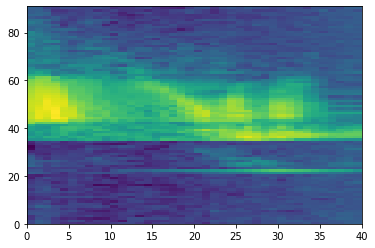

In [54]:
plt.pcolormesh(mel1)

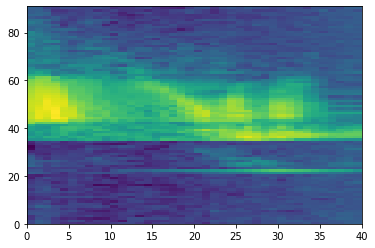

In [55]:
plt.pcolormesh(example['mspec'])

In [56]:
def cepstrum(input, nceps):
    dct1 = fftpack.realtransforms.dct(input, norm = 'ortho')[:,0 : nceps]
    return dct1

In [57]:
cepstrum1 = cepstrum(mel1,13)

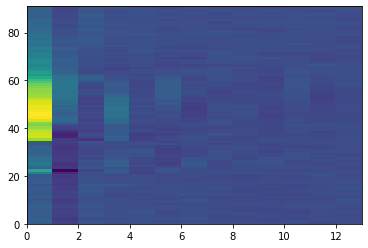

In [58]:
plt.pcolormesh(cepstrum1)

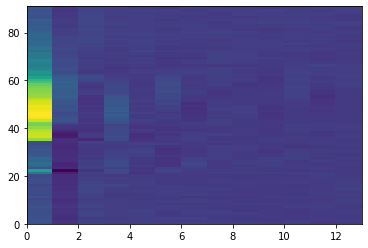

In [59]:
plt.pcolormesh(example['mfcc'])

In [60]:
lcepstrum1 = lifter(cepstrum1)

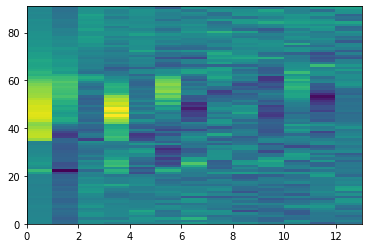

In [61]:
plt.pcolormesh(lcepstrum1)

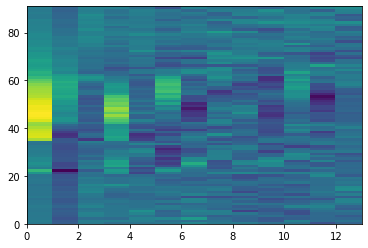

In [62]:
plt.pcolormesh(example['lmfcc'])

In [63]:
def mspec(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, samplingrate=20000):
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    return logMelSpectrum(spec, samplingrate)

In [64]:
def mfcc(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22):
    mspecs = mspec(samples, winlen, winshift, preempcoeff, nfft, samplingrate)
    ceps = cepstrum(mspecs, nceps)
    return lifter(ceps, liftercoeff)

In [65]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']

In [66]:
data.shape

(44,)

In [67]:
def mspecplot(input):
    for d in data:
        utterances = np.empty((0,40))
        mspec2 = mspec(d['samples'])
        utterances = np.concatenate((utterances,mspec2), axis=0)
    print(utterances.shape)
    return np.corrcoef(utterances.T)

In [68]:
mspecplot1 = mspecplot(data)

(79, 40)


In [69]:
def mfccplot(input):
    utterances = np.empty((0,13))
    for d in data:
        utterances = np.concatenate((utterances,mfcc(d['samples'])), axis=0)
    print(utterances.shape)
    return np.corrcoef(utterances.T)

In [70]:
mfccplot1 = mfccplot(data)

(3883, 13)


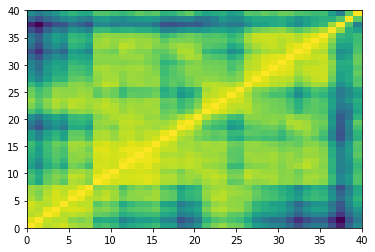

In [71]:
plt.pcolormesh(mspecplot1)

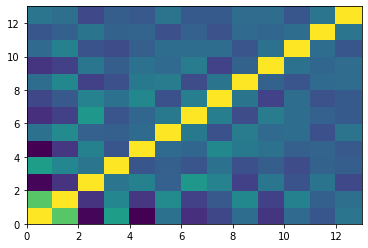

In [72]:
plt.pcolormesh(mfccplot1)

In [73]:
from sklearn.mixture import GaussianMixture

In [74]:
model = GaussianMixture(32)

In [75]:
def dtw(x, y, dist):
    
    N = x.shape[0]
    M = y.shape[0]
    LD = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            LD[i,j] = dist(x[i] - y[j])
    AD = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            AD[i, j] = LD[i, j] + minAD(AD, i, j)
    d = AD[N - 1, M - 1] / (N + M)
    path = backtrack(AD)
    return  d, LD, AD, path

In [76]:
def minAD(accD, i, j):

    if (i == 0 and j == 0):
        return 0
    elif (i == 0):
        return accD[i, j - 1]
    elif (j == 0):
        return accD[i - 1, j]
    minimum = accD[i - 1, j]
    if (accD[i - 1, j - 1] < minimum):
        minimum = accD[i - 1, j - 1]
    if (accD[i, j - 1] < minimum):
        minimum = accD[i, j - 1]
    return minimum

In [77]:
def backtrack(AD):
    N = AD.shape[0]
    M = AD.shape[1]
    path = [(N - 1, M - 1)]
    i = N - 1
    j = M - 1
    while(i > 0 or j > 0):
        if( i > 0 and j > 0):
            argmin = np.argmin([AD[i - 1, j - 1], AD[i - 1, j], AD[i, j - 1]])
            if(argmin == 0):
                path.append((i - 1, j - 1))
                i = i - 1
                j = j - 1
            elif(argmin == 1):
                path.append((i - 1, j))
                i = i - 1
            elif(argmin == 2):
                path.append((i, j - 1))
                j = j - 1
        elif(i == 0 and j > 0):
            path.append((0, j - 1))
            j = j - 1
        else:
            path.append((i - 1, 0))
            i = i - 1
    return path


In [78]:
def extract(input):
    sampled_signals = []
    signal_features = []
    for idx, sample in enumerate(data):
        sampled_signal = sample['samples']
        sampled_signals.append(sampled_signal)
        extracted_features = mfcc(sampled_signal)
        signal_features.append(extracted_features)
    return sampled_signals, signal_features

In [79]:
sample1, feature1 = extract(data)

In [80]:
len(feature1[0][1])

13

In [81]:
d1, LD1, AD1, path1 = dtw(feature1[0], feature1[1], np.linalg.norm)

In [82]:
d1

22.125880541649742

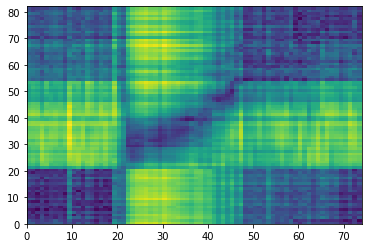

In [83]:
plt.pcolormesh(LD1)

In [84]:
AD1.shape

(82, 74)

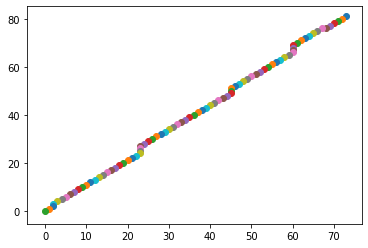

In [85]:
for i in range(83):
    plt.scatter(path1[i][1],path1[i][0])
plt.show()

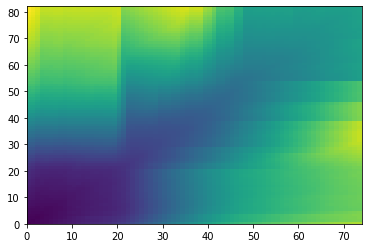

In [86]:
plt.pcolormesh(AD1)

In [87]:
def globaldistance(signal_features):
    global_distances = np.zeros((len(signal_features), len(signal_features)))
    for i in range(len(signal_features)):
        for j in range(len(signal_features)):
            d, LD, AD, path = dtw(signal_features[i], signal_features[j], np.linalg.norm)
            global_distances[i, j] = d
    return global_distances

In [88]:
globaldistance1 = globaldistance(feature1)

In [89]:
globaldistance1.shape

(44, 44)

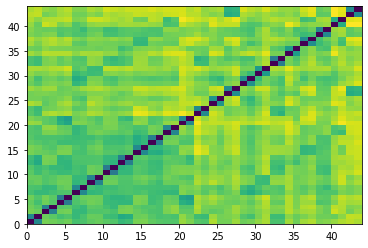

In [90]:
plt.pcolormesh(globaldistance1)

In [121]:
mfccFeatures = np.empty((0,13))
print(mfccFeatures.shape)
t = 0
for d in data:
    if(t == 0):
        mfccFeatures = np.concatenate((mfccFeatures,mfcc(d['samples'])), axis=0)
        t += 1
    else:
        a=0


(0, 13)


In [123]:
lll = [mfccFeatures[0]]

In [124]:
lll

[array([ 5.12018376, -7.36209082, 10.83460584, 10.81038625, 11.39872556,
         8.58653457, -2.46234298, -0.07665222, 24.25182714, -6.80274211,
        -2.21665088,  1.30055296, 17.83352591])]

In [125]:
n_components = [4,8,16,32]
models=[]
for i in n_components:
    model = mixture.GaussianMixture(i,covariance_type='diag')
    model.fit(lll)
    models.append(model)

ValueError: Found array with 1 sample(s) (shape=(1, 13)) while a minimum of 2 is required.

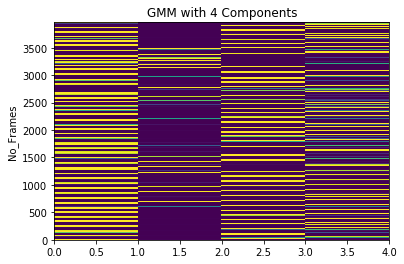

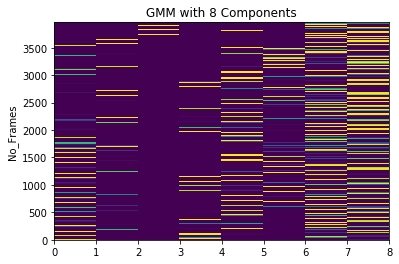

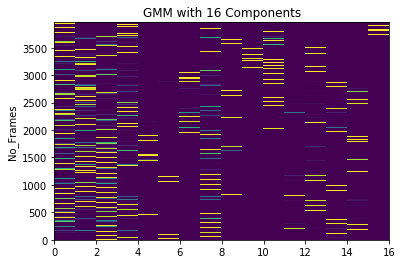

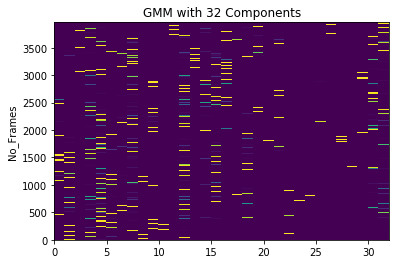

In [100]:
for i in range(4): 
    poster=models[i].predict_proba(mfccFeatures) 
    plt.ylabel('No_Frames') 
    plt.title("GMM with %d Components"%n_components[i]) 
    plt.pcolormesh(poster) 
    plt.show()

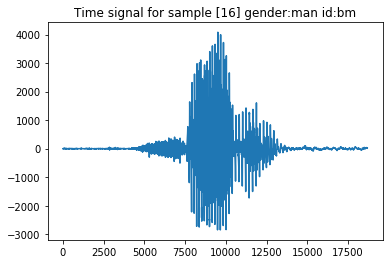

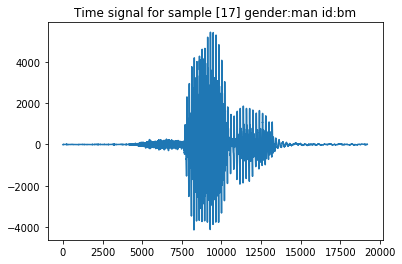

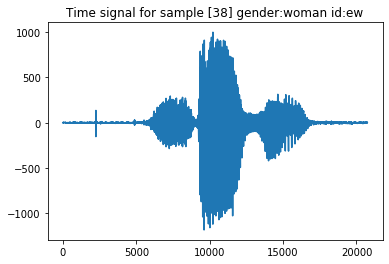

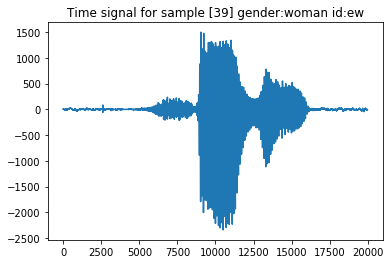

In [101]:
utterances_index = [16, 17, 38, 39]
for i in utterances_index:
    plt.title('Time signal for sample [%d] gender:%s id:%s'%(i,data[i]['gender'],data[i]['speaker']))
    plt.plot(data[i]['samples'])
    plt.show()

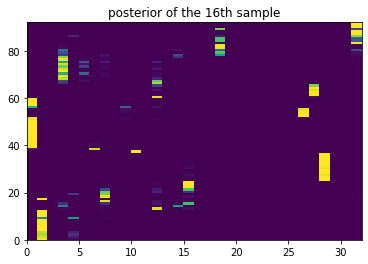

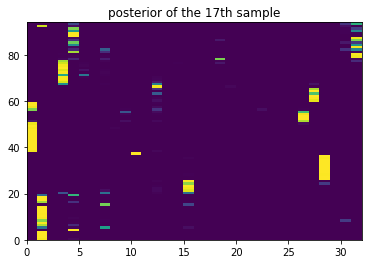

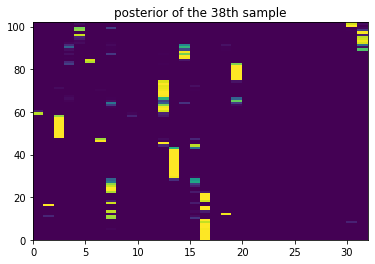

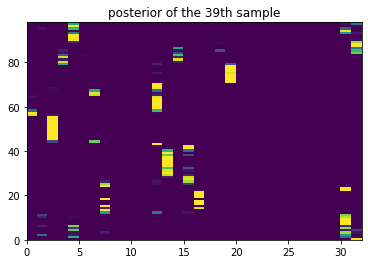

In [102]:
for i in utterances_index:
    Seven_Mfcc_Features = mfcc(data[i]['samples'])
    poster=models[3].predict_proba(Seven_Mfcc_Features)
    plt.title('posterior of the %dth sample'%i)
    plt.pcolormesh(poster)
    plt.show()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


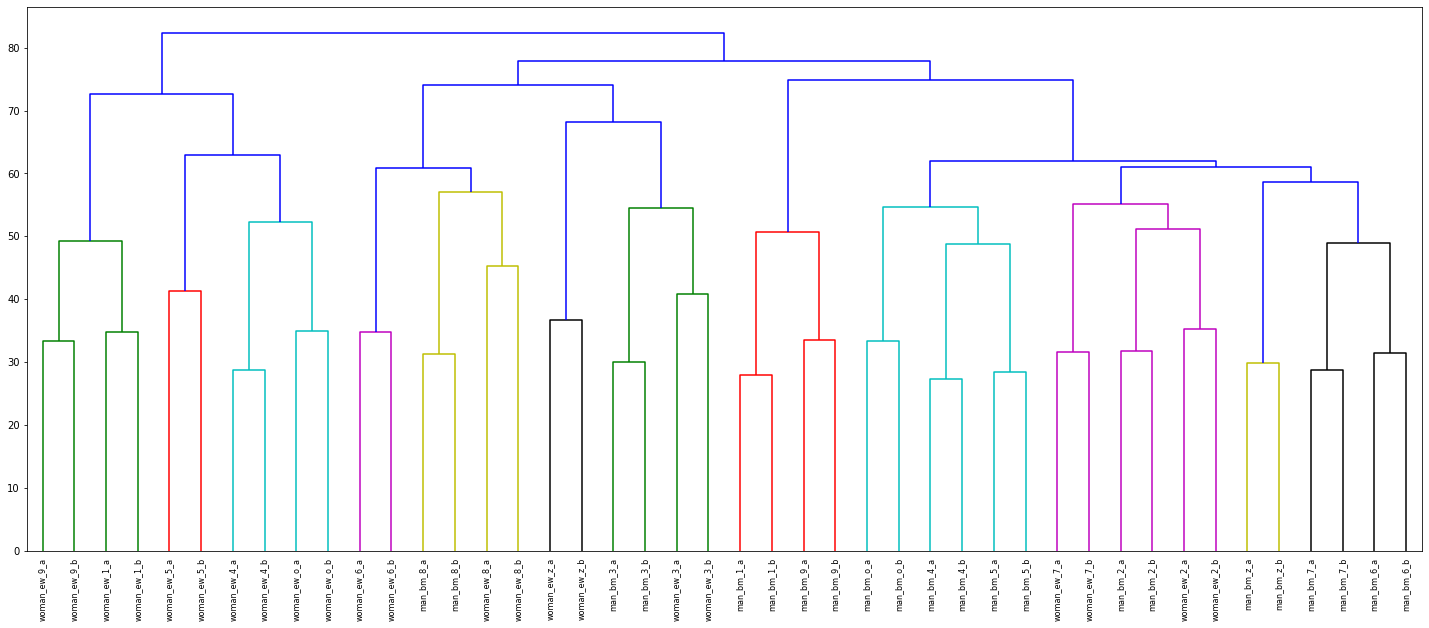

In [112]:
Z=linkage(globaldistance1, method='complete')
plt.figure(figsize=(25, 10))
dendrogram(Z,labels=tidigit2labels(data))
plt.show()